In [139]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import pi
from scipy import signal

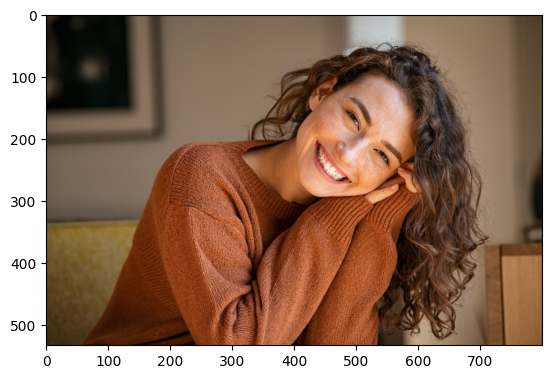

In [140]:
img = cv2.imread('../example_inputs/persona.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap='gray')

GO TO GRAYSCALE

In [141]:
def rgb2grayscale(img: np.ndarray):
    return np.around((img[:, :, 0]*0.3 + img[:, :, 1]*0.59 + img[:, :, 2]*0.11))

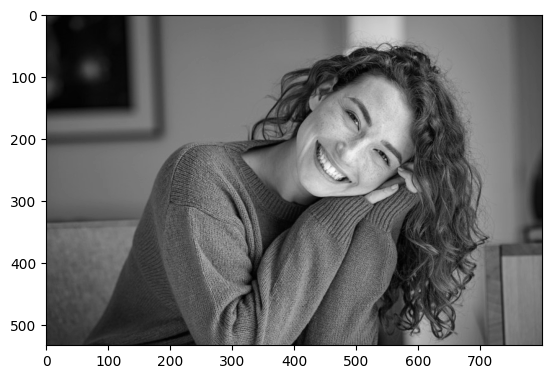

In [142]:
img_gray = rgb2grayscale(img)
plt.imshow(img_gray, cmap='gray')

DEFINE CONVOLUTION

In [143]:
def correlation(img: np.ndarray, filter: np.ndarray):
    img_x, img_y = img.shape[0], img.shape[1]
    kernel_x, kernel_y = filter.shape[0], filter.shape[1]
    if kernel_x != kernel_y:
        raise ValueError("Kernel has to be NxN")

    k = kernel_x
    new_img = np.zeros((img_x, img_y))

    pad = int((k-1)/2)

    for x in range(pad, img_x - pad):
        for y in range(pad, img_y - pad):
            subimagen = img[x - pad:x + pad + 1, y - pad:y + pad + 1]
            new_img[x, y] = np.sum(subimagen * filter)
    
    return new_img

In [144]:
def correlation(img, template):
    return signal.correlate2d(img, template)

DEFINE AND APPLY GAUSSIAN KERNEL

In [145]:
def gaussianKernel(size: int, sigma: float):
    if size % 2 == 0:
        raise ValueError("Size must be odd")
    return np.fromfunction(
        lambda x, y: (1 / ((sigma**2)*2*pi))*np.exp(-(((x-((size-1)/2))**2 + (y-((size-1)/2))**2) / (2*(sigma**2)))), (size, size)
        )

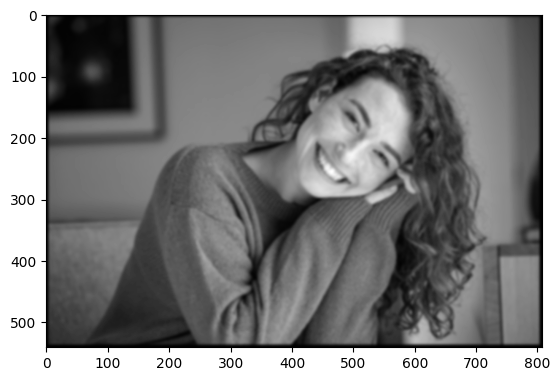

In [146]:
blurry_img = correlation(img_gray, gaussianKernel(9, 2))
plt.imshow(blurry_img, cmap='gray')

DEFINE SOBEL X AND SOBEL Y, APPLY THEM

In [147]:
sobel_y = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]])/8

sobel_x = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])/8

img_y = correlation(blurry_img, sobel_x)
img_x = correlation(blurry_img, sobel_y)

# Apply cv2.Sobel
# img_y = cv2.Sobel(blurry_img, cv2.CV_64F, 0, 1, ksize=3)
# img_x = cv2.Sobel(blurry_img, cv2.CV_64F, 1, 0, ksize=3)

Text(0.5, 1.0, 'Sobel Y')

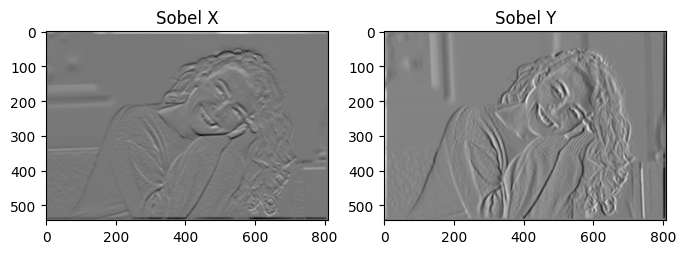

In [148]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(img_y, cmap='gray')
plt.title("Sobel X")
fig.add_subplot(1, 2, 2)
plt.imshow(img_x, cmap='gray')
plt.title("Sobel Y")

CALCULATE MAGNITUDE AND DIRECTION FROM SOBEL

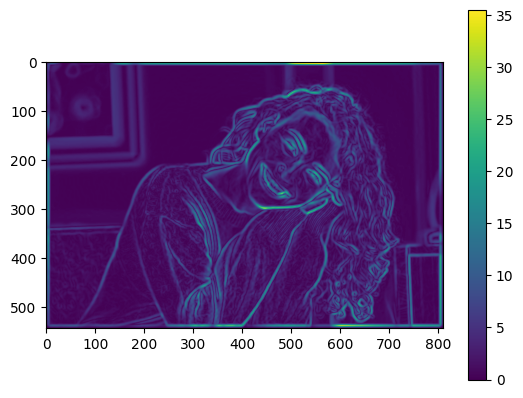

In [149]:
magnitude = np.sqrt(img_x**2 + img_y**2)
plt.imshow(magnitude, cmap='viridis')
plt.colorbar()

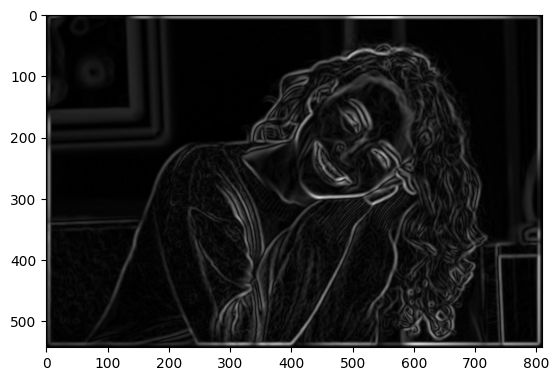

In [150]:
plt.imshow(magnitude, cmap='gray')

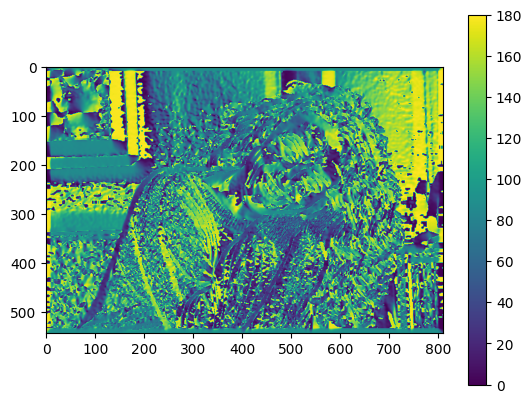

In [151]:
direction = np.arctan2(img_y, img_x)
direction_dg = direction * 180 / pi
direction_dg[direction_dg < 0] += 180
plt.imshow(direction_dg, cmap='viridis')
plt.colorbar()

NON MAXIMA POINTS ELIMINATION IN THE GRADIENT DIRECTION 

In [152]:
def nonMaximaElimination(magnitude: np.ndarray, direction: np.ndarray):
    result = magnitude.copy()

    for x in range(1, magnitude.shape[0]-1):
        for y in range(1, magnitude.shape[1]-1):
            ang = direction[x, y]
            mag = magnitude[x, y]

            if ang <= 30 or ang > 150:
                if not (mag >= magnitude[x, y+1] and mag >= magnitude[x, y-1]):
                    result[x, y] = 0

            elif 30 < ang <= 60:
                if not (mag >= magnitude[x+1, y+1] and mag >= magnitude[x-1, y-1]):
                    result[x, y] = 0

            elif 60 < ang <= 120:
                if not (mag >= magnitude[x+1, y] and mag >= magnitude[x-1, y]):
                    result[x, y] = 0
            else:
                if not (mag >= magnitude[x+1, y-1] and mag >= magnitude[x-1, y+1]):
                    result[x, y] = 0

    return result

In [153]:
img_nonMaxima = nonMaximaElimination(magnitude, direction_dg)

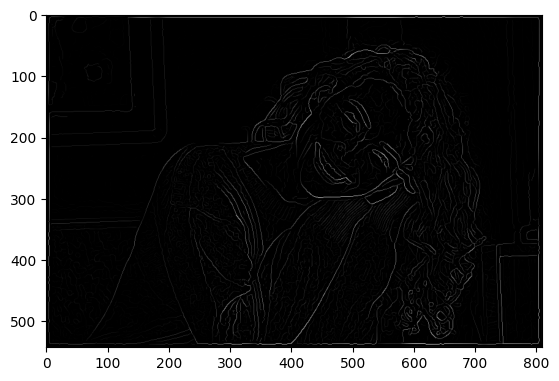

In [154]:
plt.imshow(img_nonMaxima, cmap='gray')

DOUBLE THRESHOLDING

In [155]:
def threshold(value: int, min_threshold: int, max_threshold: int):
    if value <= min_threshold:
        return 0
    elif value >= max_threshold:
        return 255
    else:
        return 128

In [156]:
threshold_v = np.vectorize(threshold)
img_threshold = threshold_v(img_nonMaxima, 3, 9)

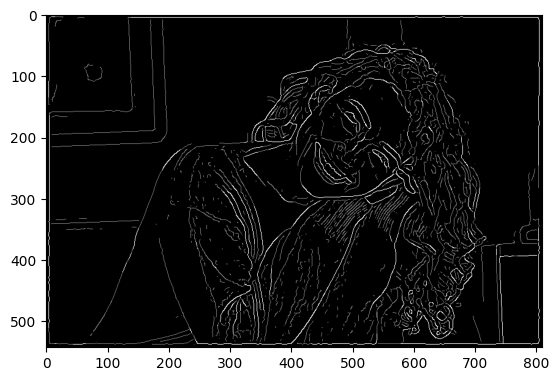

In [157]:
plt.imshow(img_threshold, cmap='gray')

In [158]:
count = np.count_nonzero(img_threshold == 150)
count

0

BORDERS BINDING

In [160]:
def hysteresis(img: np.ndarray):
    result = img.copy()
    for x in range(2, img.shape[0]-2):
        for y in range(2, img.shape[1]-2):
            if img[x, y] == 150:
                neighbors = [img[x-1, y-1], img[x-1, y], img[x-1, y+1], img[x, y+1],
                             img[x+1, y+1], img[x+1, y], img[x+1, y-1], img[x, y-1]]
                if (255 in neighbors):
                    result[x, y] = 255
                else:
                    result[x, y] = 0
    return result

In [161]:
img_bind = hysteresis(img_threshold)

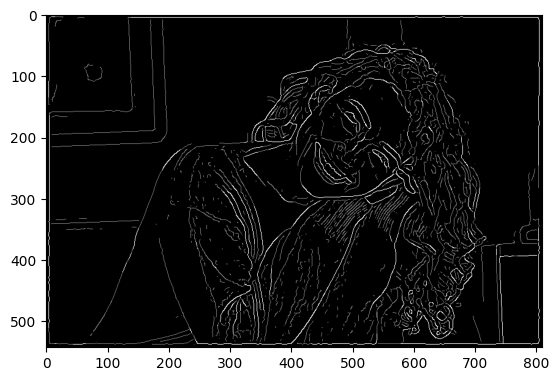

In [162]:
plt.imshow(img_bind, cmap='gray')